<a href="https://colab.research.google.com/github/vshalisko/GEE/blob/main/Colab/GDL_dos_Landsat_ANN_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Uso de ANN para clasificacion de Landsat 8 y 5
* Versión con la estandarizaciíón de datos con StandardScaler
* Clasificación en tres clases (no-urbano, urbano, agua)
* Dos modelos

In [ ]:
!pip install pyrsgis
from pyrsgis import raster, convert

Preparar el entorno

In [ ]:
import random
import math, glob, time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, cohen_kappa_score
from google.colab import drive

random.seed(2)

Coneccion con Google Drive para almacenar archivos

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Lectura de datos en formato numpy

In [ ]:
# Load the arrays as .npy files
array_feature_2015 = np.load('/content/drive/MyDrive/Colab Data/GDL_2015_feature_L8_6b.npy')
array_feature_2014 = np.load('/content/drive/MyDrive/Colab Data/GDL_2014_feature_L8_6b.npy')
array_feature_2020 = np.load('/content/drive/MyDrive/Colab Data/GDL_2020_feature_L8_6b.npy')

array_feature_2011 = np.load('/content/drive/MyDrive/Colab Data/GDL_2011_feature_L5_6b.npy')
array_feature_2010 = np.load('/content/drive/MyDrive/Colab Data/GDL_2010_feature_L5_6b.npy')
array_feature_2000 = np.load('/content/drive/MyDrive/Colab Data/GDL_2000_feature_L5_6b.npy')

array_target_binary_2015 = np.load('/content/drive/MyDrive/Colab Data/GDL_2015_target_2class.npy')
array_target_2015 = np.load('/content/drive/MyDrive/Colab Data/GDL_2015_target_3class.npy')

Transformar datos para trabajo con ANN en Keras - Tensor Flow

In [ ]:
def feature_transform(source_array):
    array_t = np.transpose(source_array, (2, 0, 1))
    print(array_t.shape)
    table_array = convert.array_to_table(array_t)
    print(table_array.shape)
    return table_array

In [ ]:
x_features_2020 = feature_transform(array_feature_2020)
x_features_2015 = feature_transform(array_feature_2015)
x_features_2014 = feature_transform(array_feature_2014)
x_features_2011 = feature_transform(array_feature_2011)
x_features_2010 = feature_transform(array_feature_2010)
x_features_2000 = feature_transform(array_feature_2000)
y_labels_2015 = feature_transform(array_target_2015)
y_labels_binary_2015 = feature_transform(array_target_binary_2015)

## codigo innecesario cuando se aplica estandarizacion StandardScaler
#y_labels_2015 = y_labels_2015 - 1
#x_features_2014 = x_features_2014 / 32768
#x_features_2015 = x_features_2015 / 32768
#x_features_2020 = x_features_2020 / 32768
nBands = x_features_2015.shape[1]

(6, 2401, 2650)
(6362650, 6)
(6, 2401, 2650)
(6362650, 6)
(6, 2401, 2650)
(6362650, 6)
(6, 2401, 2650)
(6362650, 6)
(6, 2401, 2650)
(6362650, 6)
(6, 2401, 2650)
(6362650, 6)
(1, 2401, 2650)
(6362650, 1)
(1, 2401, 2650)
(6362650, 1)


Estandarización de datos

In [ ]:
## visualización de la muestre de 50 k elementos
colors = ['orange', 'blue', 'black']
rango = slice(1000000,1050000)
colors_list = [colors[int(i) % 3] for i in y_labels_2015[rango,0]]

plt.scatter(x_features_2015[rango,0], x_features_2015[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Antes de escalado 2015')
plt.show()

scale = StandardScaler()
x_features_2020 = scale.fit_transform(x_features_2020)
x_features_2014 = scale.fit_transform(x_features_2014)
x_features_2015 = scale.fit_transform(x_features_2015)
x_features_2011 = scale.fit_transform(x_features_2011)
x_features_2010 = scale.fit_transform(x_features_2010)
x_features_2000 = scale.fit_transform(x_features_2000)

plt.scatter(x_features_2020[rango,0], x_features_2020[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2020')
plt.show()

plt.scatter(x_features_2015[rango,0], x_features_2015[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2015')
plt.show()

plt.scatter(x_features_2014[rango,0], x_features_2014[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2014')
plt.show()

plt.scatter(x_features_2011[rango,0], x_features_2011[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2011')
plt.show()

plt.scatter(x_features_2010[rango,0], x_features_2010[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2010')
plt.show()

plt.scatter(x_features_2000[rango,0], x_features_2000[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2000')
plt.show()

In [ ]:
print(x_features_2015)
print(y_labels_2015)

[[-0.98642002 -1.18470443 -1.3300849  -0.92246885 -1.25209708 -1.24958973]
 [-0.9269923  -1.15015973 -1.25753102 -1.11928967 -1.21156859 -1.22900095]
 [-0.85489966 -0.98895109 -1.16178369 -0.54006129 -0.95631023 -1.09688958]
 ...
 [-1.15593515 -0.21361432 -0.92984915 -3.20612953 -2.95038288 -2.56212469]
 [-1.19295569 -0.19288749 -0.93936441 -3.19130057 -2.95464904 -2.56384042]
 [-1.31765648 -0.2197556  -1.00121362 -3.16119327 -2.96033725 -2.56426935]]
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


Subdividir datos de entrenamiento y control (2015)

In [ ]:
xTrain, xTest, yTrain, yTest = train_test_split(x_features_2015, y_labels_2015, test_size=0.4, random_state=242)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

print(xTrain)
print(yTrain)

# Reshape the data
xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))

print(xTrain.shape, xTest.shape)

(3817590, 6)
(3817590, 1)
(2545060, 6)
(2545060, 1)
[[-0.57821979 -0.80548031 -0.96969431  0.11286255 -0.85712209 -1.15736914]
 [ 0.18167563  0.31530354  0.62113873  0.67456579  2.08865898  1.88591045]
 [-0.93576032 -1.1409478  -1.17308306 -1.09547345 -1.10207058 -1.07544293]
 ...
 [ 0.72821579  0.47881516  0.43678051 -0.61150994 -0.72309367 -0.22701347]
 [-1.11404348 -1.1294329  -1.41810108 -0.19450146 -1.09531583 -1.53697483]
 [ 0.08815004  0.26463797  0.21495594  1.54093686  0.51018107  0.35290394]]
[[0]
 [0]
 [0]
 ...
 [2]
 [0]
 [0]]
(3817590, 1, 6) (2545060, 1, 6)


Entrenar la red neuronal (ANN) simple con 2 capas ocultas

In [ ]:
from tensorflow import keras

# Define the parameters of the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(3, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Run the model
model.fit(xTrain, yTrain, epochs=5)

Epoch 1/5
119300/119300 [==============================] - 283s 2ms/step - loss: 0.1375 - accuracy: 0.9515
Epoch 2/5
119300/119300 [==============================] - 271s 2ms/step - loss: 0.1308 - accuracy: 0.9533
Epoch 3/5
119300/119300 [==============================] - 279s 2ms/step - loss: 0.1294 - accuracy: 0.9538
Epoch 4/5
119300/119300 [==============================] - 294s 2ms/step - loss: 0.1286 - accuracy: 0.9541
Epoch 5/5
119300/119300 [==============================] - 274s 2ms/step - loss: 0.1280 - accuracy: 0.9543


In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense (Dense)               (None, 20)                140       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 383 (1.50 KB)
Trainable params: 383 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
model.save('/content/drive/MyDrive/Colab Data/GDL_2015_model_ANN_2hl_3class.tensorflow')

In [ ]:
# Predict for test data
yTestPredicted_raw = model.predict(xTest)
yTestPredicted_class = yTestPredicted_raw.argmax(axis=-1)

79534/79534 [==============================] - 151s 2ms/step


In [ ]:
#yTestPredicted = yTestPredicted_raw[:,:]

## Aplicable solo para clasificacion binaria
#roc_auc_raw = roc_auc_score(yTest, yTestPredicted)
#yTestPredicted = (yTestPredicted>0.5).astype(int)
#yTestPredicted = yTestPredicted.argmax(axis=1)
#roc_auc = roc_auc_score(yTest, yTestPredicted)

## Aplicable para clasificacion multiclase
cMatrix = confusion_matrix(yTest, yTestPredicted_class)
accuracy = accuracy_score(yTest, yTestPredicted_class)
kappa = cohen_kappa_score(yTest, yTestPredicted_class)
pScore = precision_score(yTest, yTestPredicted_class, average=None)
rScore = recall_score(yTest, yTestPredicted_class, average=None)
f1Score = f1_score(yTest, yTestPredicted_class, average=None)

print("Confusion matrix:\n", cMatrix)
print("\nExactitud (accuracy): %.3f," % accuracy)
print("\nKappa de Cohen: %.3f," % kappa)
#print("\nROC AUC raw: %.3f," % roc_auc_raw)
#print("\nROC AUC: %.3f," % roc_auc)
print("\nClase 1. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[0], rScore[0], f1Score[0]))
print("\nClase 2. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[1], rScore[1], f1Score[1]))
print("\nClase 3. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[2], rScore[2], f1Score[2]))

Confusion matrix:
 [[2139815    1283   37424]
 [   7778   62560     596]
 [  68379      57  227168]]

Exactitud (accuracy): 0.955,

Kappa de Cohen: 0.812,

Clase 1. Selectividad (precision): 0.966, especificidad (recall): 0.982, f1: 0.974

Clase 2. Selectividad (precision): 0.979, especificidad (recall): 0.882, f1: 0.928

Clase 3. Selectividad (precision): 0.857, especificidad (recall): 0.768, f1: 0.810


Predicción para datos de 2015

In [ ]:
x_features_2015_n = x_features_2015
x_features_2015_n = x_features_2015_n.reshape((x_features_2015_n.shape[0], 1, x_features_2015_n.shape[1]))

predicted_2015 = model.predict(x_features_2015_n)
print(predicted_2015)

198833/198833 [==============================] - 378s 2ms/step
[[9.9941361e-01 1.7927053e-04 4.0694681e-04]
 [9.9970865e-01 7.9267993e-05 2.1207675e-04]
 [9.9897361e-01 2.7240507e-04 7.5400941e-04]
 ...
 [9.6024326e-07 9.9999899e-01 2.4697095e-24]
 [8.9576508e-07 9.9999905e-01 1.7105940e-24]
 [8.7401315e-07 9.9999917e-01 9.2445574e-25]]


Vista de la superficie de 2015 con etiquetas categoricas de mayor probabilidad

[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


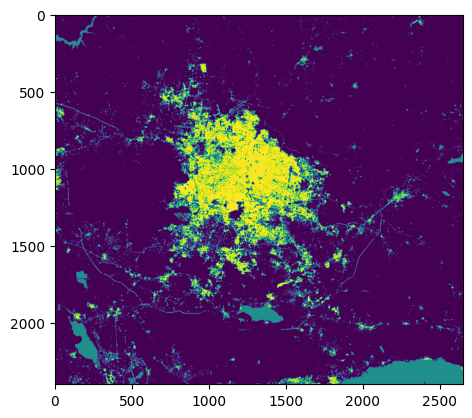

In [ ]:
predicted_2015_class = predicted_2015.argmax(axis=-1)
print(predicted_2015_class.reshape(x_features_2015_n.shape[0], 1))
predicted_2015_class_re = np.reshape(predicted_2015_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2015_class_re[:,:])
plt.show()

Superficie de probabilidad para clase urbano en 2015

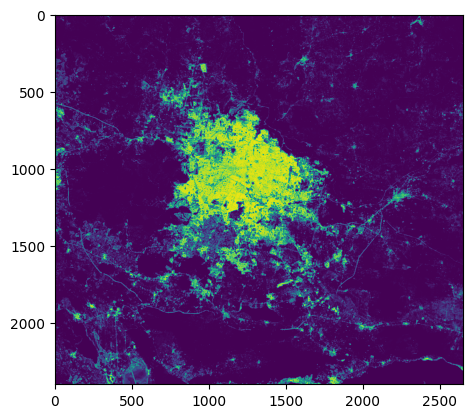

In [ ]:
prediction_2015_urbano = np.reshape(predicted_2015[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2015 = (prediction_2015_urbano).astype('float')
plt.imshow(B_img_pred_2015[:,:])
plt.show()

Predicción para 2020

In [ ]:
x_features_2020_n = x_features_2020
x_features_2020_n = x_features_2020_n.reshape((x_features_2020_n.shape[0], 1, x_features_2020_n.shape[1]))

predicted_2020 = model.predict(x_features_2020_n)
print(predicted_2020)

198833/198833 [==============================] - 377s 2ms/step
[[9.9954945e-01 1.0909437e-04 3.4133618e-04]
 [9.9974358e-01 4.7881560e-05 2.0853977e-04]
 [9.9926043e-01 2.0512781e-04 5.3452078e-04]
 ...
 [2.7955647e-07 9.9999970e-01 1.3844988e-26]
 [3.2068644e-07 9.9999964e-01 2.0857572e-26]
 [2.8750262e-07 9.9999976e-01 1.6338980e-26]]


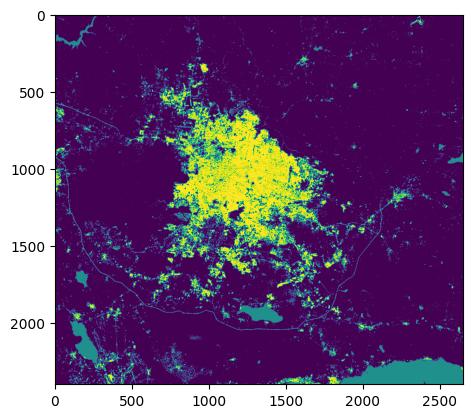

In [ ]:
predicted_2020_class = predicted_2020.argmax(axis=-1)
predicted_2020_class_re = np.reshape(predicted_2020_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2020_class_re[:,:])
plt.show()

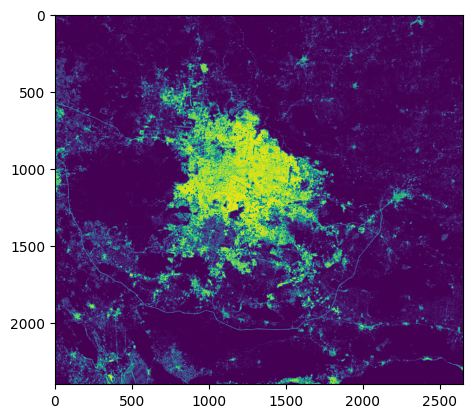

In [ ]:
prediction_2020_urbano = np.reshape(predicted_2020[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2020 = (prediction_2020_urbano).astype('float')
plt.imshow(B_img_pred_2020[:,:])
plt.show()


Predicción para 2014

In [ ]:
x_features_2014_n = x_features_2014
x_features_2014_n = x_features_2014_n.reshape((x_features_2014_n.shape[0], 1, x_features_2014_n.shape[1]))

predicted_2014 = model.predict(x_features_2014_n)
print(predicted_2014)

198833/198833 [==============================] - 367s 2ms/step
[[9.9953181e-01 1.8981242e-04 2.7835424e-04]
 [9.9938828e-01 2.2538363e-04 3.8632244e-04]
 [9.9794465e-01 6.0593634e-04 1.4494641e-03]
 ...
 [2.7427645e-06 9.9999720e-01 1.2620001e-22]
 [2.7375643e-06 9.9999726e-01 1.3514775e-22]
 [2.5231320e-06 9.9999750e-01 1.0624717e-22]]


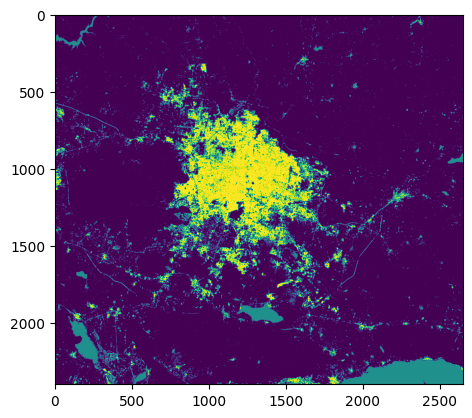

In [ ]:
predicted_2014_class = predicted_2014.argmax(axis=-1)
predicted_2014_class_re = np.reshape(predicted_2014_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2014_class_re[:,:])
plt.show()

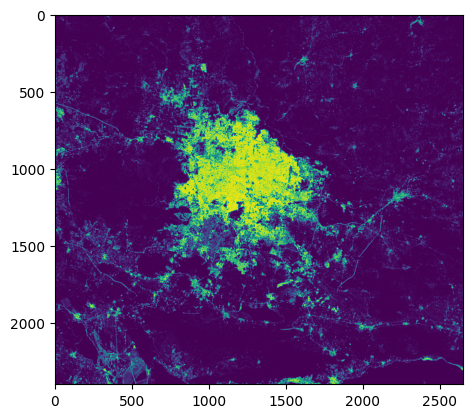

In [ ]:
prediction_2014_urbano = np.reshape(predicted_2014[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2014 = (prediction_2014_urbano).astype('float')
plt.imshow(B_img_pred_2014[:,:])
plt.show()

Guardar capas numpy de prediccion

In [ ]:
# Save the arrays as .npy files
np.save('/content/drive/MyDrive/Colab Data/GDL_2014_prediction_class.npy', predicted_2014_class)
np.save('/content/drive/MyDrive/Colab Data/GDL_2015_prediction_class.npy', predicted_2015_class)
np.save('/content/drive/MyDrive/Colab Data/GDL_2020_prediction_class.npy', predicted_2020_class)
np.save('/content/drive/MyDrive/Colab Data/GDL_2014_prediction_urbano_float.npy', prediction_2014_urbano)
np.save('/content/drive/MyDrive/Colab Data/GDL_2015_prediction_urbano_float.npy', prediction_2015_urbano)
np.save('/content/drive/MyDrive/Colab Data/GDL_2020_prediction_urbano_float.npy', prediction_2020_urbano)

In [ ]:
x_features_2011_n = x_features_2011
x_features_2011_n = x_features_2011_n.reshape((x_features_2011_n.shape[0], 1, x_features_2011_n.shape[1]))

y_target_2011_n = predicted_2015_class.reshape(x_features_2015_n.shape[0], 1)

print(x_features_2011_n.shape, y_target_2011_n.shape)

# Define the parameters of the model
model1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(3, activation='softmax')])

# Define the accuracy metrics and parameters
model1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Run the model
model1.fit(x_features_2011_n, y_target_2011_n, epochs=5)

(6362650, 1, 6) (6362650, 1)
Epoch 1/5
198833/198833 [==============================] - 519s 3ms/step - loss: 0.1180 - accuracy: 0.9596
Epoch 2/5
198833/198833 [==============================] - 600s 3ms/step - loss: 0.1146 - accuracy: 0.9606
Epoch 3/5
198833/198833 [==============================] - 538s 3ms/step - loss: 0.1142 - accuracy: 0.9607
Epoch 4/5
198833/198833 [==============================] - 508s 3ms/step - loss: 0.1139 - accuracy: 0.9608
Epoch 5/5
198833/198833 [==============================] - 566s 3ms/step - loss: 0.1137 - accuracy: 0.9608


In [ ]:
model1.save('/content/drive/MyDrive/Colab Data/GDL_2011_model_ANN_2hl_3class.tensorflow')

In [ ]:
x_features_2010_n = x_features_2010
x_features_2010_n = x_features_2010_n.reshape((x_features_2010_n.shape[0], 1, x_features_2010_n.shape[1]))

predicted_2010 = model.predict(x_features_2010_n)
print(predicted_2010)

198833/198833 [==============================] - 373s 2ms/step
[[9.99304295e-01 6.54190488e-04 4.16341245e-05]
 [9.99919116e-01 5.61104898e-05 2.47296757e-05]
 [9.88612711e-01 1.11850752e-02 2.02201176e-04]
 ...
 [9.72750240e-06 9.99990165e-01 4.13689436e-17]
 [1.14546665e-05 9.99988556e-01 1.30112930e-16]
 [2.12583814e-06 9.99997854e-01 3.09926248e-19]]


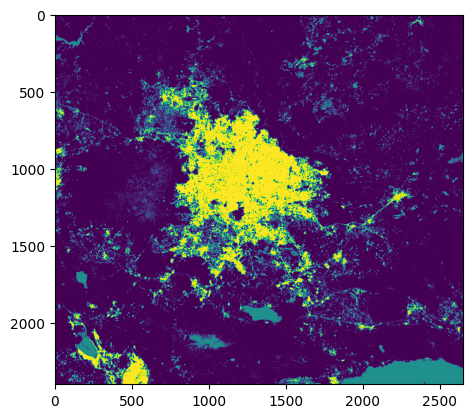

In [ ]:
predicted_2010_class = predicted_2010.argmax(axis=-1)
predicted_2010_class_re = np.reshape(predicted_2010_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2010_class_re[:,:])
plt.show()

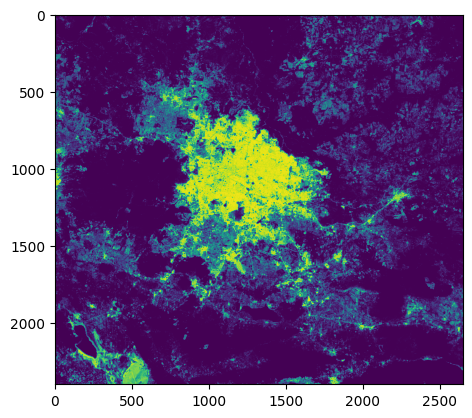

In [ ]:
prediction_2010_urbano = np.reshape(predicted_2010[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2010 = (prediction_2010_urbano).astype('float')
plt.imshow(B_img_pred_2010[:,:])
plt.show()

In [ ]:
x_features_2000_n = x_features_2000
x_features_2000_n = x_features_2000_n.reshape((x_features_2000_n.shape[0], 1, x_features_2000_n.shape[1]))

predicted_2000 = model.predict(x_features_2000_n)
print(predicted_2000)

198833/198833 [==============================] - 392s 2ms/step
[[9.9983001e-01 4.9373164e-05 1.2065887e-04]
 [9.9784213e-01 2.0269877e-03 1.3097348e-04]
 [9.9904829e-01 8.2795334e-05 8.6889626e-04]
 ...
 [5.4322377e-02 9.4531631e-01 3.6145453e-04]
 [7.2643779e-02 9.2678601e-01 5.7021086e-04]
 [1.1779826e-01 8.8207239e-01 1.2937510e-04]]


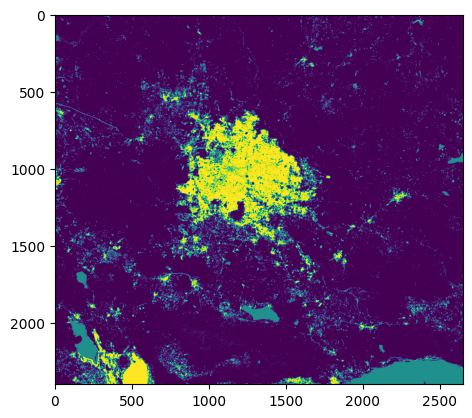

In [ ]:
predicted_2000_class = predicted_2000.argmax(axis=-1)
predicted_2000_class_re = np.reshape(predicted_2000_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2000_class_re[:,:])
plt.show()

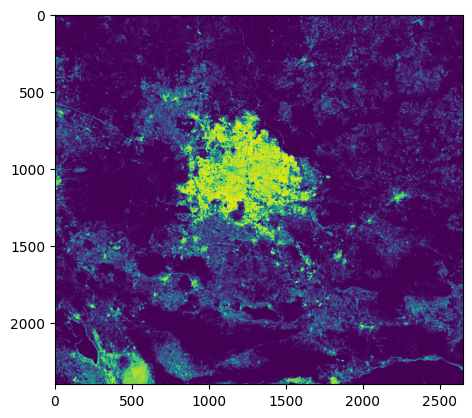

In [ ]:
prediction_2000_urbano = np.reshape(predicted_2000[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2000 = (prediction_2000_urbano).astype('float')
plt.imshow(B_img_pred_2000[:,:])
plt.show()

In [ ]:
# Save the arrays as .npy files
np.save('/content/drive/MyDrive/Colab Data/GDL_2010_prediction_class.npy', predicted_2010_class)
np.save('/content/drive/MyDrive/Colab Data/GDL_2000_prediction_class.npy', predicted_2000_class)
np.save('/content/drive/MyDrive/Colab Data/GDL_2010_prediction_urbano_float.npy', prediction_2010_urbano)
np.save('/content/drive/MyDrive/Colab Data/GDL_2000_prediction_urbano_float.npy', prediction_2000_urbano)